# Google Landmark Retrieval Challenge using Transfer Learning
It is based on the following pytorch tutorial: [Here] (https://pytorch.org/docs/stable/torchvision/transforms.html)


The dataset has been uploaded to Google drive and used on Google Colaboratory environment.

**Authors: ** Natik Amine, Driouiche Younes

## Installing a Pillow version > 4.3.0 

Otherwise you get nasty errors. Also, you need to **restart** Google colab enviornment after installing PILLOW (the next cell)
Answered this question on Stackoverflow: (https://stackoverflow.com/a/53245643/4786728)

In [0]:
!pip install Pillow==5.3.0

In [0]:
import PIL
print(PIL.PILLOW_VERSION)
PIL.__version__

5.3.0


'5.3.0'

## Downloading Pytorch

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5baba000 @  0x7fd466de22a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


## Importing Torch --  Cuda and PyTorch Verification

In [0]:
import torch
cuda_available = torch.cuda.is_available()
print(cuda_available)
print(torch.__version__)

True
0.4.0


## Mounting google drive in the Colab environment

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Useful Imports

In [0]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import copy

## Setting the device to GPU if available

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preparing Data 

In [0]:
os.chdir('/content/gdrive/My Drive/GLRC')
!cp hw7data.tar '/content/hw7data.tar'
os.chdir('/content/')

In [0]:
!tar -xf hw7data.tar

In [0]:
!cd hw7data ; ls

images	sampleSubmission.txt  test.csv	train.csv


## Computing the mean and variance of Images for normalization

**GOAL for pytorch**: have data in folder structure like : /data/img_target/image.jpg

Exploring the data.

In [0]:
    # Exploring the data:
path = '/content/hw7data/'
train_df = pd.read_csv(os.path.join(path,'train.csv'), delimiter=',')
print(len(train_df))
# Renaming columns of the data frame:
train_df.columns = ['index','id', 'url', 'label']
img_id = '0e97e3245fe375b3'
img_label_row = train_df.loc[train_df['id'] == img_id]
print(img_label_row.iloc[0]['label'])

30317
0


A function for debugging purposes:

In [0]:
def print_for_debug(*msgs, bool_verbose = True):
    if bool_verbose:
        print(msgs)

Printing The total number of Images we have:

In [0]:
imgs_path = os.path.join(path,'images')
directory = os.fsencode(imgs_path)
len(os.listdir(directory))

67420

In [0]:
def images_to_target_folders(bool_verbose = False):
    path = '/content/hw7data/'
    # Make train and valid folders
    train_path = os.path.join(path,'train')
    imgs_path = os.path.join(path,'images')
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    # Loading labels and ids of images
    train_df = pd.read_csv(os.path.join(path,'train.csv'), delimiter=',')
    # Renaming columns of the data frame:
    train_df.columns = ['index','id', 'url', 'label']
    
    # Load images from directory
    directory = os.fsencode(imgs_path)
    for img in os.listdir(directory):
        img_name = os.fsdecode(img)
        img_id = img_name[:-4]
        # Get the label of the img
        # I notice that some images are like:
        # '._ID.jpg' and some are like 'ID.jpg'
        # -_ID.jpg are apparently corrupted files, so ignore them
        img_label = train_df.loc[train_df['id'] == img_id] 
        if img_label.empty == False :
            img_label = img_label.iloc[0]['label']
        else:
            img_label = -1
        # Check if this label exists        
        if img_label != -1:
            img_label = str(img_label)
            # Add images to training folder given the condition below
            
            directory = os.path.join(train_path, img_label)

            # Create a folder with that label in the right folder if it doesn't exist
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Move the image to the right folder
            src = os.path.join(imgs_path, img_name)
            dest = os.path.join(directory, img_name)
            
            os.rename(src, dest)

Romoving old files, so that we avoid duplicates if any exist

In [0]:
!rm -r /content/hw7data/train

### Creating the training and validation sets:

In [0]:
# Creating the folders now:
images_to_target_folders()

In [0]:
!cd hw7data/train; ls

0  1  2  3  4  5  6  7	8  9


### Counting the number of images in each folder for verification:

In [0]:
val = !cd hw7data/train;  find '.' -name '*.jpg' | wc -l

In [0]:
print(int(val[0]))

29846


## Computing the Mean and Variance of the data for the transforms

The model works well without needing this, but it is good to use the compute the statistics on our dataset, instead of the stats of ImageNet Dataset

In [0]:
def compute_mean_stddev():
    data_path = '/content/hw7data'
    transform = transforms.Compose([transforms.ToTensor()])
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), transform) for x in ['train']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1024, shuffle=False)
                   for x in ['train']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
    means = []
    stds = []
    for dataset_type in ['train']:
        for id_x, (inputs, labels) in enumerate(dataloaders[dataset_type]):
            print('Batch: ',id_x)
            means.append(torch.mean(inputs, 1, True))
            stds.append(torch.std(inputs, 1, True))
#     return {'mean': means, 'stds': stds}
    return {'mean':torch.mean(torch.Tensor(means), dim = 0),'stdev': torch.mean(torch.Tensor(stds), dim = 0)}

In [0]:
#stats_dict = compute_mean_stddev()

## Creating the normalized validation and training set:

In [0]:
stats_dict = {'mean': [0.485, 0.456, 0.406] , 'stdev': [0.229, 0.224, 0.225]}
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(stats_dict['mean'], stats_dict['stdev'])
    ])
}

data_path = '/content/hw7data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True)
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes

## Visualizing Images

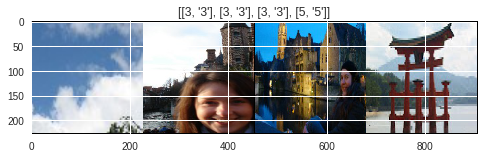

In [0]:
def imshow(inp, stats_dict, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = stats_dict['mean']
    std = stats_dict['stdev']
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4,:,:,:])

imshow(out, stats_dict, title=[[x.item(),class_names[x]] for x in classes[0:4]])

# Pre-trained CNN Model:
RestNet with 18 layers was used as in the PyTorch tutorial. The whole model was trained as we have a relatively big dataset.

## The training function


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase -- validation removed
        for phase in ['train']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training the model 

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 68346813.98it/s]


The model was trained for more than 2 epochs, then trained again one more epoch to improve the performance.

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.1858 Acc: 0.9410

Training complete in 6m 45s
Best Accuracy: 0.941031


# Producing predictions using the newly trained model:

## Getting predictions on the Test dataset

In [0]:
!cd hw7data ; rm -r test

rm: cannot remove 'test': No such file or directory


In [0]:
def images_to_test(bool_verbose = False):
    path = '/content/hw7data/'
    # Make train and valid folders
    test_path = os.path.join(path,'test')
    test_path = os.path.join(test_path,'images')
    imgs_path = os.path.join(path,'images')
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    # Loading labels and ids of images
    test_df = pd.read_csv(os.path.join(path,'test.csv'), delimiter=',')
    # Renaming columns of the data frame:
    test_df.columns = ['index','id', 'url']
    
    n_samples = test_df.shape[0]

    # Load images from directory
    directory = os.fsencode(imgs_path)
    for img in os.listdir(directory):
        img_name = os.fsdecode(img)
        img_id = img_name[:-4]
        # I notice that some images are like:
        # '._ID.jpg' and some are like 'ID.jpg'
        # -_ID.jpg are apparently corrupted files, so ignore them
        img_exists = not test_df.loc[test_df['id'] == img_id].empty
        if img_exists == True:
            # Move the image to the right folder
            src = os.path.join(imgs_path, img_name)
            dest = os.path.join(test_path, img_name)
            os.rename(src, dest)

In [0]:
images_to_test()

In [0]:
test = !cd hw7data/test/images;  find '.' -name '*.jpg' | wc -l
print(test)

['3391']


## The following function will caluclate the predictions at the same order as in the test.csv file

In [0]:
def test_images(model):
    path = '/content/hw7data/'
    # Make train and valid folders
    test_path = os.path.join(path,'test')
    test_path = os.path.join(test_path,'images')
    # Loading labels and ids of images
    test_df = pd.read_csv(os.path.join(path,'test.csv'), delimiter=',')
    # Renaming columns of the data frame:
    test_df.columns = ['index','id', 'url']
    stats_dict = {'mean': [0.485, 0.456, 0.406] , 'stdev': [0.229, 0.224, 0.225]}
    testdata_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize(stats_dict['mean'], stats_dict['stdev'])
    ])
    was_training = model.training
    model.eval()
    fd = open("predictions_submission.txt","w")
    fd.write('landmark_id\n')
    with torch.no_grad():
        for index, row in test_df.iterrows():
            img_id = row['id'] + '.jpg'
            img = PIL.Image.open(os.path.join(test_path,img_id))
            inputs = testdata_transforms(img)
            inputs = inputs.unsqueeze(0)
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                # Adding +1 because the network was trained with labels off 1.
                fd.write(str(pred.item())+'\n')
        model.train(mode=was_training)
        
# Running the function:
test_images(model_ft)

### Download the submission  file from Google colab

In [0]:
download = True
if download:
    from google.colab import files
    files.download('predictions_submission.txt') 

The above function will probably output slightly different predictions because images are randomely cropped. 

## Visualizing predictions on the validation set

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} -- True Label: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j],stats_dict)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

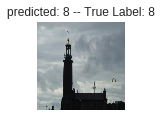

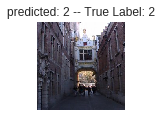

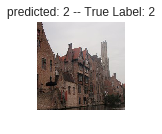

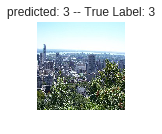

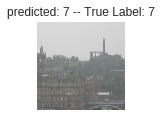

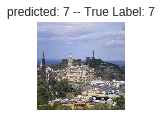

In [0]:
visualize_model(model_ft, num_images=6)